# Building a Spam Filter with Naive Bayes

In this guided project, we're going to study the practical side of the Naive Bayes algorithm by building a spam filter for SMS messages. The dataset we will use was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) and also available on [this link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where you can also find some of the authors' papers.

To classify messages as spam or non-spam, the computer:

- Learns how humans classify messages.
- Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
- Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

Our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans. 

### Exploring the dataset

In [1]:
# read the file using pandas
import pandas as pd
# No header row in the dataset
# Use the names=['Label', 'SMS'] parameter to name the columns
sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])
print(sms.shape)
sms.head(5)

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


It seems like "ham" was used to describe non-spam. There are 5572 rows and  2 columns in the dataset.

In [2]:
df = pd.DataFrame(sms['Label'].value_counts())
df['Percentage'] = sms['Label'].value_counts(normalize=True)*100
df

,Label,Percentage
ham,4825,86.593683
spam,747,13.406317


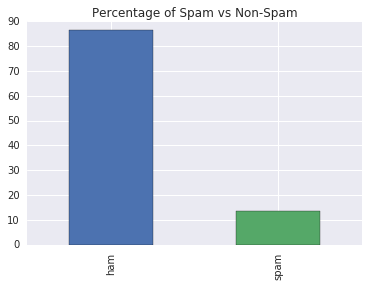

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set the sns style
% matplotlib inline
df['Percentage'].plot.bar(title='Percentage of Spam vs Non-Spam')

About 87% of the messages are ham ("ham" means non-spam), and the remaining 13% are spam. We can now move on to building the spam filter.

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

- A training set, which we'll use to "train" the computer how to classify messages.
- A test set, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).


## Training and Test Set 

Our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

We're going to start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset. 

In [4]:
# Randomising the entire dataset
# frac=1 to randomize the entire dataset
sms_random = sms.sample(frac=1, random_state=1)
sms_random.head(10)

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...
5461,ham,Ok i thk i got it. Then u wan me 2 come now or...
4210,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...
4216,ham,No dear i was sleeping :-P
1603,ham,Ok pa. Nothing problem:-)
1504,ham,Ill be there on &lt;#&gt; ok.


We will now split the randomized dataset into a training and a test set. The training set should account for 80% of the dataset, and the remaining 20% of the data should be the test set.

In [5]:
# Finding the number of rows for each sets
training_index = round(len(sms_random)*0.8)
test_index = round(len(sms_random)*0.2)
print(training_index)
test_index

4458


1114

We will extract the first 4458 rows from our dataset for the training set and the last 1114 rows for the test set.

In [6]:
training_set = sms_random.copy().iloc[:4458].reset_index(drop=True)
test_set = sms_random.copy().iloc[-1114:].reset_index(drop=True)
print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [7]:
training_set.tail(5) # checking the last few rows of the training set

,Label,SMS
4453,ham,"Sorry, I'll call later in meeting any thing re..."
4454,ham,Babe! I fucking love you too !! You know? Fuck...
4455,spam,U've been selected to stay in 1 of 250 top Bri...
4456,ham,Hello my boytoy ... Geeee I miss you already a...
4457,ham,Wherre's my boytoy ? :-(


In [8]:
test_set.head(5) # checking the first few rows of the training set

,Label,SMS
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


In [9]:
sms_random.iloc[4457:4460] # Checking if the test and training set has been extracted correctly

,Label,SMS
3482,ham,Wherre's my boytoy ? :-(
2131,ham,Later i guess. I needa do mcat study too.
3418,ham,But i haf enuff space got like 4 mb...


### Spam vs Non-Spam in Training and Test Set

In [10]:
df_train = pd.DataFrame(training_set['Label'].value_counts())
df_train['Percentage'] = training_set['Label'].value_counts(normalize=True)*100
df_train

,Label,Percentage
ham,3858,86.54105
spam,600,13.45895


In [11]:
df_test = pd.DataFrame(test_set['Label'].value_counts())
df_test['Percentage'] = test_set['Label'].value_counts(normalize=True)*100
df_test

,Label,Percentage
ham,967,86.804309
spam,147,13.195691


In [12]:
df_difference = pd.DataFrame(df_train['Percentage']-df_test['Percentage'])
df_difference

,Percentage
ham,-0.263259
spam,0.263259


In the original dataset there are about 86.6% of non-spam messages which is very similar to both training (86.5%) and test set (86.8%). A difference of less than 0.3% gives very good indication of the randomness of our training and test set.

## Letter Case and Punctuation

The next step is to use the training set to teach the algorithm to classify new messages. Before we calculate the probabilities using the Naive Bayes algorithm, we'll first need to perform some data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

To make the calculations easier, we want bring the data to a format where it is a dataframe with all unique words labelled into columns and the frequencies of each word will be displayed in each row (message).

We'll begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [13]:
# A function to remove any character that is not from a-z, A-Z or 0-9
import re
def punctuation(text):
    return re.sub('\W', ' ', text)

training_set['SMS'] = training_set['SMS'].apply(punctuation)
training_set.head(5)

,Label,SMS
0,ham,Yep by the pretty sculpture
1,ham,Yes princess Are you going to make me moan
2,ham,Welp apparently he retired
3,ham,Havent
4,ham,I forgot 2 ask ü all smth There s a card on ...


In [14]:
# To transform every letter in every word to lower case for each message
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head(5)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [15]:
# Applying both punctuation function and lower method to test set
test_set['SMS'] = test_set['SMS'].apply(punctuation).str.lower()
test_set.head(5)

,Label,SMS
0,ham,later i guess i needa do mcat study too
1,ham,but i haf enuff space got like 4 mb
2,spam,had your mobile 10 mths update to latest oran...
3,ham,all sounds good fingers makes it difficult ...
4,ham,all done all handed in don t know if mega sh...


### Creating the Vocabulary

Before we created the columns for each unique words, we need to create a list with all of the unique words that occur in the messages of our training set. We will call the set of unique words a vocabulary.

In [16]:
# splitting the string at the space character 
training_set['SMS'] = training_set['SMS'].str.split() 
# initiate an empty list
vocabulary = []
training_set['SMS'].head(5)

0                    [yep, by, the, pretty, sculpture]
1    [yes, princess, are, you, going, to, make, me,...
2                      [welp, apparently, he, retired]
3                                             [havent]
4    [i, forgot, 2, ask, ü, all, smth, there, s, a,...
Name: SMS, dtype: object

In [17]:
# iterate over the SMS column
for row in training_set['SMS']:
    for word in row:
        vocabulary.append(word)
# Display the first 20 words in the vocabulary list
vocabulary[:20]

['yep',
 'by',
 'the',
 'pretty',
 'sculpture',
 'yes',
 'princess',
 'are',
 'you',
 'going',
 'to',
 'make',
 'me',
 'moan',
 'welp',
 'apparently',
 'he',
 'retired',
 'havent',
 'i']

In [18]:
# Duplicates in the list
vocabulary.count('yep')

9

To remove duplicates in the list, we can transform the vocabulary list into a set then transform the vocabulary set back into a list.

In [19]:
vocabulary = list(set(vocabulary))
# checking if the number of count = 1 for each unique word
print(vocabulary.count('yep')) 
print(vocabulary.count('you'))
print(vocabulary.count('to'))

1
1
1


In [20]:
len(vocabulary)

7783

There are 7783 unique words in the vocabulary dictionary.

## The Final Training Set
Now we're going to use the vocabulary to make the data transformation we need. We'll first build a dictionary that we'll then convert to the DataFrame we need.

To create the dictionary we need for our training set, we can use the steps below:

- Start by initializing a dictionary named word_counts_per_sms, where each key is a unique word from the vocabulary, and each value is a list of the length of training set, where each element in the list is a 0.
- Loop over training_set 'SMS' column using at the same time the built-in enumerate() function to get both the index and the SMS message (index and sms).

In [21]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS'])
                      for unique_word in vocabulary}

# Loop over SMS column
for index, sms in enumerate(training_set['SMS']):
    # Nested loop over sms(a list of strings)
    for word in sms:
        # word = find the correct key in the dictionary
        # index  = add 1 to the correct index in the list (value for the key)
        word_counts_per_sms[word][index] += 1

In [22]:
# Transform word_counts_per_sms into a DataFrame 
training_word = pd.DataFrame(word_counts_per_sms)
training_word.head(5)

,0,00,000,000pes,008704050406,0089,01223585334,02,0207,02072069400,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


Now we will concatenate the DataFrame we just built above with the DataFrame containing the training set so we'll also have the Label and the SMS columns in the DataFrame.

In [23]:
# Concatenate the DataFrame we just built above with the DataFrame containing the training set
final_training = pd.concat([training_set, training_word], axis=1)
final_training.head(5)

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [24]:
# Check if the added columns corresponds to the other columns
final_training['sculpture'].head(3)

0    1
1    0
2    0
Name: sculpture, dtype: int64

## Calculating Constants First

Now we have the  training set ready, we can begin creating the spam filter. 

The Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:

<img src="formula.png">

To calculate P(w<sub>i</sub> | Spam) and P(w<sub>i</sub>| Ham) inside the formulas above, we need to use these equations:

<img src="formula1.png">

Let's first calculate:

- P(Spam) and P(Ham)
- N<sub>Spam</sub>, N<sub>Ham</sub>, N<sub>Vocabulary</sub>

All these terms will have constant values in our equations for every new message (regardless of the message or each individual word in the message).

We'll also use Laplace smoothing and set alpha = 1.


### P(Spam) and P(Ham)

We will use the training to set to calculate P(Spam) and P(Ham) by using the number of rows labelled as Spam and Ham.

In [25]:
# P(Spam)
spam = len(final_training[final_training['Label']=='spam'])
total = len(final_training)
p_spam = spam/total
p_spam

0.13458950201884254

In [26]:
ham = len(final_training[final_training['Label']=='ham'])
p_ham = ham/total
p_ham

0.8654104979811574

### N<sub>Spam</sub>, N<sub>Ham</sub> & N<sub>Vocabulary</sub>

**Definitions:**
- N<sub>Spam</sub> is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.

- N<sub>Ham</sub> is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.

In [27]:
# N(Spam)
words_spam = 0
spam_training = final_training[final_training['Label']=='spam']
for sms in spam_training['SMS']:
    for word in sms:
        words_spam += 1

# N(Ham)
words_ham = 0        
ham_training = final_training[final_training['Label']=='ham']
for sms in ham_training['SMS']:
    for word in sms:
        words_ham += 1
        
print(words_spam)
print(words_ham)

# Initiate variable alpha
alpha = 1

15190
57237


## Calculating Parameters

P(w<sub>i</sub> | Spam) and P(w<sub>i</sub> | Ham) will vary depending on the individual words. For instance, P("secret"|Spam) will have a certain probability value, while P("cousin"|Spam) or P("lovely"|Spam) will most likely have other values.

Although both P(w<sub>i</sub> | Spam) and P(w<sub>i</sub> | Ham) vary depending on the word, the probability for each individual word is constant for every new message. To help save the computation time when the  system receives a message, we can calculate the probabilities beforehand.

To calculate all the parameters, we need to use the equations below:

<img src="formula3.png">

In [28]:
# Initialise two dictionaries to store the parameters for Spam and Ham

# P(wi|Spam)
parameters_spam = {}
# P(wi|Ham)
parameters_ham = {}

In [29]:
# Iterate over the vocabulary and for each word, calculate the parameters

# Spam
for unique_word in vocabulary:
    n_word_spam = 0
    for sms in spam_training['SMS']:
        for word in sms:
            if word == unique_word:
                n_word_spam += 1
    numerator =  n_word_spam + alpha
    denominator = words_spam + alpha*len(vocabulary)
    p_word_spam = numerator/denominator
    parameters_spam[unique_word] = p_word_spam

# Ham
for unique_word in vocabulary:
    n_word_ham = 0
    for sms in ham_training['SMS']:
        for word in sms:
            if word == unique_word:
                n_word_ham += 1
    numerator =  n_word_ham + alpha
    denominator = words_ham + alpha*len(vocabulary)
    p_word_ham = numerator/denominator
    parameters_ham[unique_word] = p_word_ham

## Classifying A New Message

Now that we've calculated all the constants and parameters we need, we are ready to start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w1,..., wn)
- Calculates P(Spam|w1, ..., wn) and P(Ham|w1,..., wn)
- Compares the values of P(Spam|w1,..., wn) and P(Ham|w1,..., wn), and:
    - If P(Ham|w1,..., wn) is bigger  P(Spam|w1,..., wn), then the message is classified as ham.
    - If P(Ham|w1,..., wn) < P(Spam|w1,..., wn), then the message is classified as spam.
    - If P(Ham|w1,..., wn) = P(Spam|w1,..., wn), then the algorithm may request human help.


In [30]:
import re

def classify(message):
    # remove the punctuation, lowercase, split into a list of words
    message = re.sub('\W', ' ', message).lower().split()
    
    # Calculating probabilities of Spam and Ham given message
        # initiate p_spam_given_message and p_ham_given_message
        # incase the words that are not part of the vocabulary
    p_spam_given_message = p_spam 
    p_ham_given_message = p_ham
    #loop over the input of the function
    for word in message:
        if word in parameters_spam:
            # update the initiated value
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            # update the initiated value
            p_ham_given_message *= parameters_ham[word]
        # we ignore the words that are not part of the vocabulary

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal probabilities, need human input')
        
# Testing our function 
classify("WINNER!! This is the secret code to unlock the money: C3421.")
classify("Sounds good, Tom, then see u there")

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam
P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Measuring the Spam Filter's Accuracy

Now we'll try to determine how well the spam filter does using our test set of 1,114 messages. The algorithm will output a classification label for every message in our test set, which we'll be able to compare with the actual label (given by a human). 

*Note that, in training, our algorithm didn't see these 1,114 messages, so every message in the test set is practically new from the perspective of the algorithm. *

First, we'll need to change the classify() function that we wrote previously to return the labels instead of printing them. 

In [31]:
def classify_test_set(message):
    # remove the punctuation, lowercase, split into a list of words
    message = re.sub('\W', ' ', message).lower().split()
    
    # Calculating probabilities of Spam and Ham given message
        # initiate p_spam_given_message and p_ham_given_message
        # incase the words that are not part of the vocabulary
    p_spam_given_message = p_spam 
    p_ham_given_message = p_ham
    #loop over the input of the function
    for word in message:
        if word in parameters_spam:
            # update the initiated value
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            # update the initiated value
            p_ham_given_message *= parameters_ham[word]
        # we ignore the words that are not part of the vocabulary

    if p_ham_given_message > p_spam_given_message:
        return('ham')
    elif p_ham_given_message < p_spam_given_message:
        return('spam')
    else:
        return('needs human classification')

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [32]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head(10)

,Label,SMS,predicted
0,ham,later i guess i needa do mcat study too,ham
1,ham,but i haf enuff space got like 4 mb,ham
2,spam,had your mobile 10 mths update to latest oran...,spam
3,ham,all sounds good fingers makes it difficult ...,ham
4,ham,all done all handed in don t know if mega sh...,ham
5,ham,but my family not responding for anything now...,ham
6,ham,u too,ham
7,ham,boo what time u get out u were supposed to ta...,ham
8,ham,genius what s up how your brother pls send h...,ham
9,ham,i liked the new mobile,ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use accuracy as a metric:

<img src="formula4.png">

### Accuracy of The Spam Filter

In [33]:
correct = 0
# number of messages in the test set
total = len(test_set['SMS']) 
# Iterate over the test set DataFrame as (index, Series) pairs
for index, row in test_set.iterrows():
    if row['Label'] == row['predicted']:
        correct += 1
        
accuracy = correct/total
accuracy

0.9874326750448833

## Conclusion and Further Improvements

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. We initially aimed for an accuracy of over 80%, but we managed to do way better than that.

Potential improvement to the project:

- Isolate the 14 messages that were classified incorrectly and try to figure out why the algorithm reached the wrong conclusions.
- Make the filtering process more complex by making the algorithm sensitive to letter case.